<a href="https://colab.research.google.com/github/Hussein-Ahmad-94/Tasks/blob/main/Metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A metadata configuration for Ensemble Transfer Learning <br> for Time Series

In [ ]:
#Import dependances
import tensorflow as tf
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

### Import the dataset

In [ ]:
df_1 = pd.read_pickle('/content/df_01.pkl')

In [ ]:
df_1.columns

Index(['load', 'load_norm'], dtype='object')

In [ ]:
df_1.shape

(43820, 2)

In [ ]:
#Slice the dataset
# slice_num = 5000

# df_1 = df_1.iloc[:slice_num,:]

In [ ]:
# #data = [1,2,3,4,5,6,7,8,9,10,11, 12, 13, 14, 15]
# #data = [1,2,3,4,5,6,7,8,9,10,11]
# data = [1,2,3,4,5]
# df = pd.DataFrame(data, columns=['Numbers'])

### EDA (Exploratory Data Analysis)

<AxesSubplot:xlabel='date'>

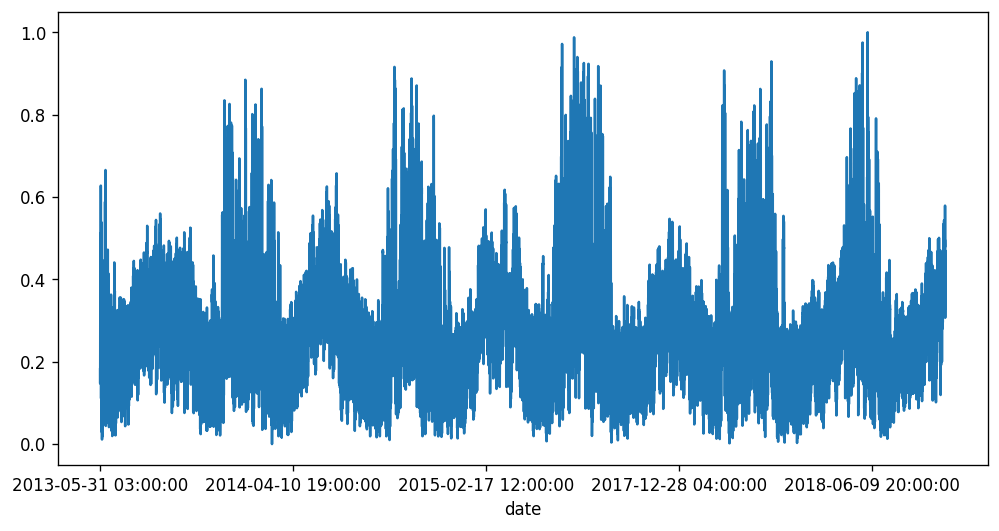

In [ ]:
plt.figure(figsize=(10, 5), dpi=120)
df_1['load_norm'].plot()

### Split the data in Train and Test

In [ ]:
# A 80-20 (Train-Test Split)
train_perc = 0.80        #(20 - 80)
split = int(len(df_1) * train_perc)

df_train, df_test = df_1[:split], df_1[split:]


#Remember to reset the Indexes
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


#### <span style='color:red'> SINGLE-STEP (Single Horizon) </span>

In [ ]:
def makeXyMeta(ts, nb_timesteps):
    """
    Inputs:
        ts: original time series
        nb_timesteps: number of time steps in the regressors
    Output:
        X: 2-D array of regressors
        y: 1-D array of target
    """
    X =        []
    y =        []
    X_meta =   []

    for i in range(nb_timesteps,ts.shape[0]):
        X_lag =   []
        y_hor =   []
        meta_lag= []

        X_lag = list(ts.loc[i-nb_timesteps:i-1])
        y_hor = ts.loc[i]

        #----Meta data----------
        T_first  = X_lag[0]
        T_middle = X_lag[(len(X_lag) // 2)]
        T_last   = X_lag[-1]
        T_min    = np.array(X_lag).min()
        T_Q1     = np.percentile(X_lag, 25)
        T_Q2     = np.percentile(X_lag, 50)
        T_Q3     = np.percentile(X_lag, 75)
        T_max    = np.array(X_lag).max()

        meta_lag = [T_first, T_middle, T_last, T_min, T_Q1, T_Q2, T_Q3, T_max]
        #-----------------------

        X.append(X_lag)
        y.append(y_hor)
        X_meta.append(meta_lag)
    X, X_meta, y = np.array(X), np.array(X_meta), np.array(y)
    return X, X_meta, y

## <span style='color:green'> Dependancies for Models </span>

In [ ]:
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
#Callback to later save the best model
from tensorflow.keras.callbacks import ModelCheckpoint

#Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

import datetime
import os

### MLP Model

In [ ]:
# A Function to make the MLP
def make_regression_mlp(TIME_STEPS = 6, n_nodes_1 = 2, OUTPUT = 1):

    initializer='uniform'
    learning_rate = 0.001
    opt = tf.keras.optimizers.Adam(learning_rate)
    loss='mse'
    activation='relu'  # relu.

    model = Sequential()

    model.add(Input(shape=(TIME_STEPS,), dtype='float32'))
    model.add(Dense(units= n_nodes_1, kernel_initializer='uniform', activation=activation))
    model.add(Dense(OUTPUT, kernel_initializer=initializer))

    model.compile(loss=loss, optimizer=opt)

    return model

### Make the Model

In [ ]:
##Hyperparameters

N_LAGS_NORM = 5

#Always 8
N_LAGS_META = 8

N_HORIZONS = 1

BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
import IPython

display(IPython.display.Javascript('''
  const promise = new Promise((resolve, reject) => {
    const script = document.createElement('script');
    script.src = 'data:,window.value = "hello world!"';
    script.onload = resolve;
    script.onerror = reject;
    document.head.appendChild(script);
  });
  // Pause subsequent outputs until the script has been loaded.
  google.colab.output.pauseOutputUntil(promise);
'''))

display(IPython.display.Javascript('''
    // Can immediately reference scripts loaded earlier since
    // output processing was blocked on them.
    document.body.appendChild(document.createTextNode(window.value));
'''))


### Make the (X,y)

In [ ]:
X_train, X_train_meta, y_train = makeXyMeta(df_train['load_norm'], N_LAGS_NORM)
X_test, X_test_meta, y_test    = makeXyMeta(df_test['load_norm'], N_LAGS_NORM)

In [ ]:
mlp_nn_1_norm    = make_regression_mlp(TIME_STEPS = N_LGS_NAORM, n_nodes_1 = 1,  OUTPUT = N_HORIZONS)
mlp_nn_1_meta    = make_regression_mlp(TIME_STEPS = N_LAGS_META, n_nodes_1 = 1,  OUTPUT = N_HORIZONS)

# mlp_nn_2    = make_regression_mlp(TIME_STEPS = N_LAGS, n_nodes_1 = 2,  OUTPUT = N_HORIZONS)
# mlp_nn_5    = make_regression_mlp(TIME_STEPS = N_LAGS, n_nodes_1 = 5,  OUTPUT = N_HORIZONS)
# mlp_nn_10   = make_regression_mlp(TIME_STEPS = N_LAGS, n_nodes_1 = 10,  OUTPUT = N_HORIZONS)
# mlp_nn_20   = make_regression_mlp(TIME_STEPS = N_LAGS, n_nodes_1 = 20,  OUTPUT = N_HORIZONS)

# mlp_nn_30   = make_regression_mlp(TIME_STEPS = N_LAGS, n_nodes_1 = 30,  OUTPUT = N_HORIZONS)
# mlp_nn_50   = make_regression_mlp(TIME_STEPS = N_LAGS, n_nodes_1 = 50,  OUTPUT = N_HORIZONS)
# mlp_nn_100  = make_regression_mlp(TIME_STEPS = N_LAGS, n_nodes_1 = 100, OUTPUT = N_HORIZONS)
# mlp_nn_200  = make_regression_mlp(TIME_STEPS = N_LAGS, n_nodes_1 = 200, OUTPUT = N_HORIZONS)

### Fit (Train the Model)

In [ ]:
#Train with Normal data
mlp_nn_1_norm.fit(X_train, y_train, verbose=0, batch_size=BATCH_SIZE, epochs=EPOCHS)

In [ ]:
#Train with Meta data
mlp_nn_1_meta.fit(X_train_meta, y_train, verbose=0, batch_size=BATCH_SIZE, epochs=EPOCHS)

### <span style='color:red'> Plot the Train and Val Loss </span>

In [ ]:
#The Training Loss and Validation Loss will be plotted Here !!!

### Make the Prediction

In [ ]:
y_pred_norm = mlp_nn_1_norm.predict(X_test)
y_pred_meta = mlp_nn_1_meta.predict(X_test_meta)

### Evaluation Metrics

### <span style='color:green'> For Normal data </span>

In [ ]:
r2_norm  = r2_score(y_test, y_pred_norm)
rmse_norm = sqrt(mean_squared_error(y_test, y_pred_norm))
mape_norm = mean_absolute_percentage_error (y_test, y_pred_norm)

(r2_norm, rmse_norm, mape_norm)

(-0.019247933572278608, 0.10513956438618137, 0.39296233229909855)

### <span style='color:blue'> For Meta data </span>

In [ ]:
r2_meta  = r2_score(y_test, y_pred_meta)
rmse_meta = sqrt(mean_squared_error(y_test, y_pred_meta))
mape_meta = mean_absolute_percentage_error (y_test, y_pred_meta)

(r2_meta, rmse_meta, mape_meta)

(-0.015126997080125992, 0.10492680344522892, 0.39481546868870127)

In [ ]:
import pandas as pd
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error


# Set the hyperparameters
n_nodes_list = [1,2,5,10,20,30,50,70,100,200]
n_lags_norm_list = [5,7, 9, 19, 41, 101]
n_lags_meta = 8
N_HORIZONS = 1
BATCH_SIZE = 128
EPOCHS = 100
N_HORIZONS = 1

# Initialize the results table
results_table = pd.DataFrame(columns=[
    'num_nodes', 'num_lags_norm', 'n_lags_meta',
    'r2_norm', 'rmse_norm', 'mape_norm',
    'r2_meta', 'rmse_meta', 'mape_meta'
])

# Loop over the hyperparameters
start = time.time()
for num_nodes in n_nodes_list:
    for num_lags_norm in n_lags_norm_list:
            # Prepare the data

            X_train, X_train_meta, y_train = makeXyMeta(df_train['load_norm'], num_lags_norm)
            X_test, X_test_meta, y_test = makeXyMeta(df_test['load_norm'], num_lags_norm)

            # Create and train the models
            mlp_nn_norm = make_regression_mlp(TIME_STEPS=num_lags_norm, n_nodes_1=num_nodes, OUTPUT=N_HORIZONS)
            mlp_nn_meta = make_regression_mlp(TIME_STEPS=n_lags_meta, n_nodes_1=num_nodes, OUTPUT=N_HORIZONS)
            mlp_nn_norm.fit(X_train, y_train, verbose=0, batch_size=BATCH_SIZE, epochs=EPOCHS)
            mlp_nn_meta.fit(X_train_meta, y_train, verbose=0, batch_size=BATCH_SIZE, epochs=EPOCHS)

            # Make predictions and compute metrics
            y_pred_norm = mlp_nn_norm.predict(X_test)
            y_pred_meta = mlp_nn_meta.predict(X_test_meta)
            r2_norm = r2_score(y_test, y_pred_norm)
            rmse_norm = sqrt(mean_squared_error(y_test, y_pred_norm))
            mape_norm = mean_absolute_percentage_error(y_test, y_pred_norm)
            r2_meta = r2_score(y_test, y_pred_meta)
            rmse_meta = sqrt(mean_squared_error(y_test, y_pred_meta))
            mape_meta = mean_absolute_percentage_error(y_test, y_pred_meta)

            # Add the results to the table
            results_table = results_table.append({
                'num_nodes': num_nodes,
                'num_lags_norm': num_lags_norm,
                'n_lags_meta': n_lags_meta,
                'r2_norm': r2_norm,
                'rmse_norm': rmse_norm,
                'mape_norm': mape_norm,
                'r2_meta': r2_meta,
                'rmse_meta': rmse_meta,
                'mape_meta': mape_meta
            }, ignore_index=True)
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")

274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 1s 3ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 0s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 0s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 0s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 1s 3ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 0s 1ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 2ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 3ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


274/274 [==============================] - 1s 3ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


273/273 [==============================] - 1s 3ms/step


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


271/271 [==============================] - 1s 2ms/step
Runtime of the program is 9929.202011585236


<ipython-input-10-4c0bf8d6eb05>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_table = results_table.append({


In [ ]:
# Print the results table
print(results_table)

# Save the results table to a CSV file
results_table.to_csv('results.csv', index=False)

    num_nodes  num_lags_norm  n_lags_meta   r2_norm  rmse_norm  mape_norm  \
0         1.0            5.0          8.0  0.970446   0.024675   0.090761   
1         1.0            7.0          8.0  0.970884   0.024493   0.087230   
2         1.0            9.0          8.0 -0.016514   0.144715   0.786887   
3         1.0           19.0          8.0 -0.022913   0.145177   0.797942   
4         1.0           41.0          8.0 -0.025105   0.145350   0.797134   
5         1.0          101.0          8.0  0.984606   0.017804   0.059021   
6         2.0            5.0          8.0  0.970512   0.024648   0.089444   
7         2.0            7.0          8.0 -0.026054   0.145402   0.803831   
8         2.0            9.0          8.0 -0.022698   0.145154   0.798105   
9         2.0           19.0          8.0 -0.028455   0.145570   0.806842   
10        2.0           41.0          8.0  0.983066   0.018681   0.062243   
11        2.0          101.0          8.0  0.984635   0.017787   0.060224   

In [ ]:
df=pd.read_csv("/content/lag_5.csv")

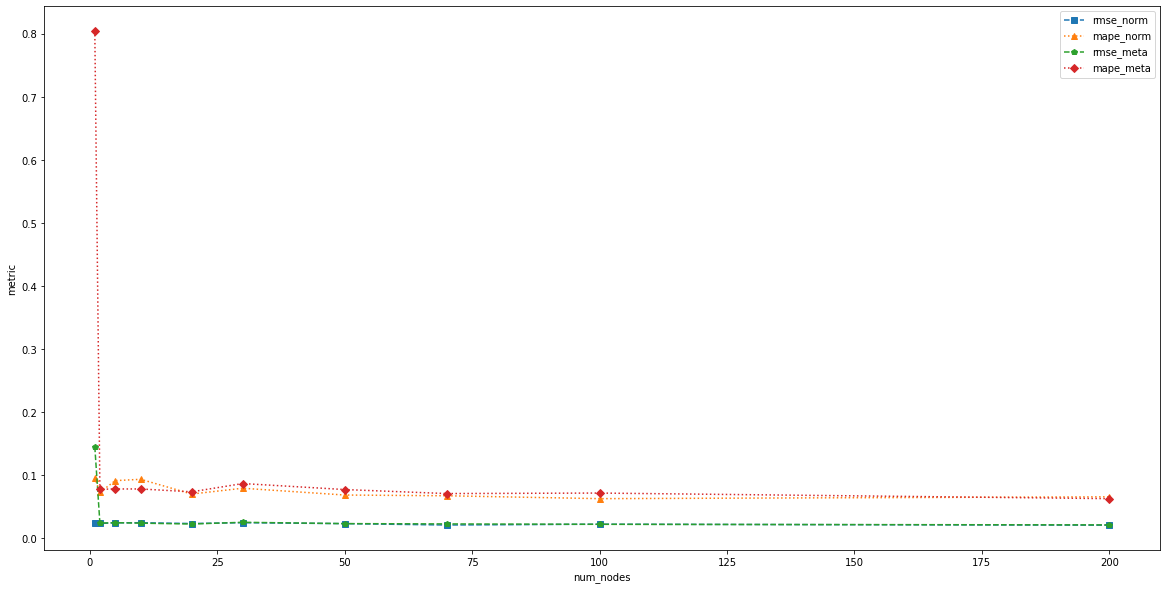

In [ ]:
import matplotlib.pyplot as plt

# Example data
data = {
    'num_nodes': [1, 2, 5, 10, 20, 30, 50, 70, 100, 200],

    'rmse_norm': [0.025065, 0.023602, 0.024646, 0.024838, 0.023543, 0.024821, 0.023356, 0.02118, 0.02246, 0.020905],
    'mape_norm': [0.096287, 0.07282, 0.091487, 0.09363, 0.070275, 0.079467, 0.068702, 0.067521, 0.062959, 0.065902],

    'rmse_meta': [0.145409, 0.024137, 0.024912, 0.024111, 0.022763, 0.025493, 0.023404, 0.022907, 0.02228, 0.021378],
    'mape_meta': [0.804083, 0.077824, 0.07832, 0.078317, 0.073774, 0.086892, 0.077374, 0.071019, 0.071817, 0.062973]
}

# Plotting
plt.figure(figsize=(20,10))

plt.plot(data['num_nodes'], data['rmse_norm'], 's--', label='rmse_norm')
plt.plot(data['num_nodes'], data['mape_norm'], '^:', label='mape_norm')

plt.plot(data['num_nodes'], data['rmse_meta'], 'p--', label='rmse_meta')
plt.plot(data['num_nodes'], data['mape_meta'], 'D:', label='mape_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('metric')
plt.legend()

# Show the plot
plt.show()


## Lag=5:


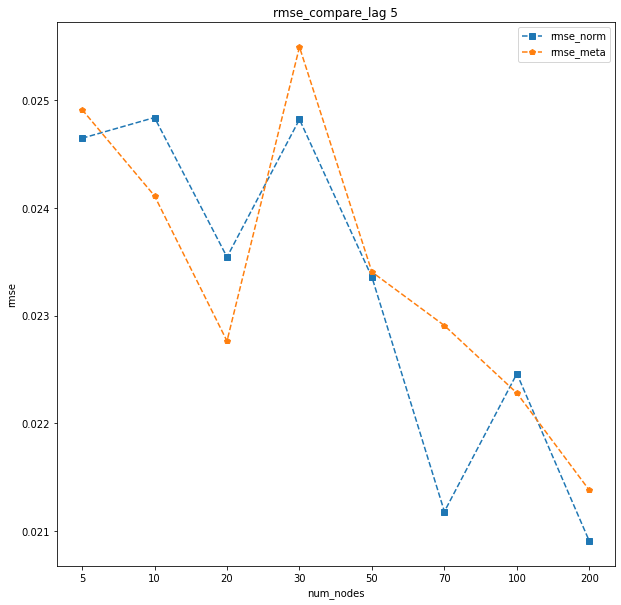

In [ ]:
data = {
    'num_nodes': ["5", "10", "20", "30", "50", "70", "100", "200"],
    'r2_norm': [0.969505, 0.972962, 0.970516, 0.970055, 0.973097, 0.970096, 0.973523, 0.978227, 0.975516, 0.978788],
    'rmse_norm': [0.025065, 0.023602, 0.024646, 0.024838, 0.023543, 0.024821, 0.023356, 0.02118, 0.02246, 0.020905],
    'mape_norm': [0.096287, 0.07282, 0.091487, 0.09363, 0.070275, 0.079467, 0.068702, 0.067521, 0.062959, 0.065902],
    'r2_meta': [-0.026276, 0.971721, 0.969877, 0.971783, 0.974849, 0.968455, 0.973412, 0.974531, 0.975906, 0.977818],
    'rmse_meta': [0.145409, 0.024137, 0.024912, 0.024111, 0.022763, 0.025493, 0.023404, 0.022907, 0.02228, 0.021378],
    'mape_meta': [0.804083, 0.077824, 0.07832, 0.078317, 0.073774, 0.086892, 0.077374, 0.071019, 0.071817, 0.062973]
}

# Plotting
plt.figure(figsize=(10,10))
plt.plot(data['num_nodes'], data['rmse_norm'][2:], 's--', label='rmse_norm')
plt.plot(data['num_nodes'], data['rmse_meta'][2:], 'p--', label='rmse_meta')


# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('rmse')
plt.title("rmse_compare_lag 5")
plt.legend()




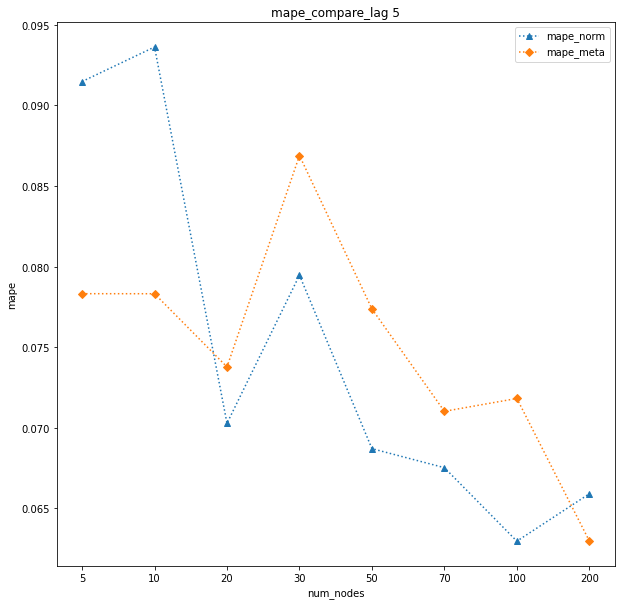

In [ ]:
data = {
    'num_nodes': ["5", "10", "20", "30", "50", "70", "100", "200"],
    'r2_norm': [0.969505, 0.972962, 0.970516, 0.970055, 0.973097, 0.970096, 0.973523, 0.978227, 0.975516, 0.978788],
    'rmse_norm': [0.025065, 0.023602, 0.024646, 0.024838, 0.023543, 0.024821, 0.023356, 0.02118, 0.02246, 0.020905],
    'mape_norm': [0.096287, 0.07282, 0.091487, 0.09363, 0.070275, 0.079467, 0.068702, 0.067521, 0.062959, 0.065902],
    'r2_meta': [-0.026276, 0.971721, 0.969877, 0.971783, 0.974849, 0.968455, 0.973412, 0.974531, 0.975906, 0.977818],
    'rmse_meta': [0.145409, 0.024137, 0.024912, 0.024111, 0.022763, 0.025493, 0.023404, 0.022907, 0.02228, 0.021378],
    'mape_meta': [0.804083, 0.077824, 0.07832, 0.078317, 0.073774, 0.086892, 0.077374, 0.071019, 0.071817, 0.062973]
}

# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['mape_norm'][2:], ':^', label='mape_norm')
plt.plot(data['num_nodes'], data['mape_meta'][2:], ':D', label='mape_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('mape')
plt.title("mape_compare_lag 5")
plt.legend()

# Show the plot
plt.show()

## Lag=7:


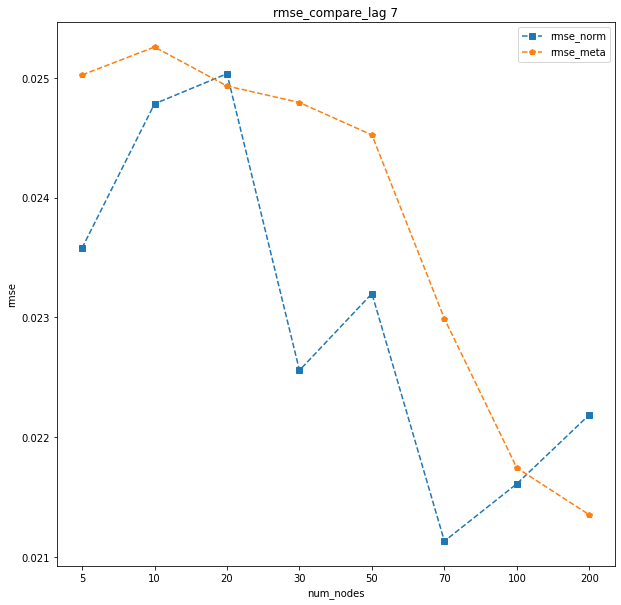

In [ ]:
data = {
    'num_nodes': [ "5", "10", "20", "30", "50", "70", "100", "200"],
    'num_lags_norm': [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
    'num_lags_meta': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    'r2_norm': [-0.027291, 0.970473, 0.973018, 0.970194, 0.969587, 0.975303, 0.973881, 0.978324, 0.97733, 0.976106],
    'rmse_norm': [0.14549, 0.024666, 0.023579, 0.024782, 0.025033, 0.022559, 0.023199, 0.021134, 0.021613, 0.022189],
    'mape_norm': [0.805785, 0.086543, 0.0698, 0.07874, 0.075741, 0.066196, 0.087868, 0.062811, 0.064552, 0.072222],
    'r2_meta': [-0.02181, 0.968974, 0.969612, 0.969043, 0.969835, 0.970168, 0.970816, 0.974348, 0.977053, 0.977871],
    'rmse_meta': [0.145101, 0.025284, 0.025023, 0.025256, 0.024931, 0.024793, 0.024522, 0.02299, 0.021745, 0.021354],
    'mape_meta': [0.796793, 0.084767, 0.081223, 0.081097, 0.08478, 0.076157, 0.081406, 0.078002, 0.065151, 0.061952]
}

# Plotting
plt.figure(figsize=(10,10))
plt.plot(data['num_nodes'], data['rmse_norm'][2:], 's--', label='rmse_norm')
plt.plot(data['num_nodes'], data['rmse_meta'][2:], 'p--', label='rmse_meta')


# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('rmse')
plt.title("rmse_compare_lag 7")
plt.legend()

# Show the plot
plt.show()



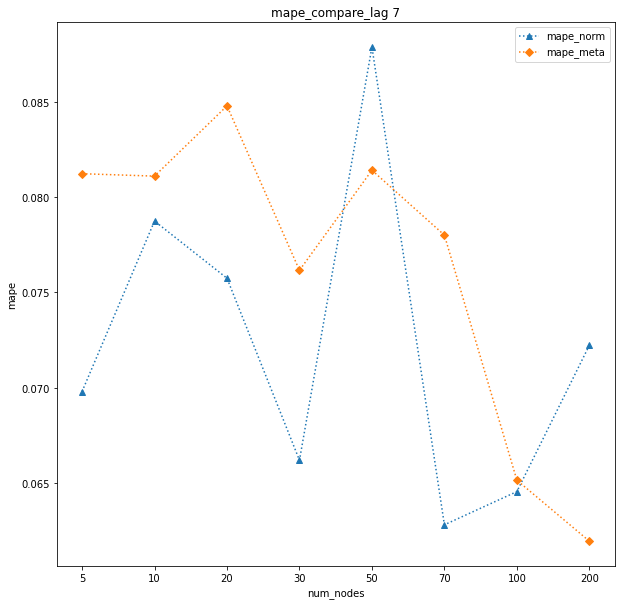

In [ ]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['mape_norm'][2:], ':^', label='mape_norm')
plt.plot(data['num_nodes'], data['mape_meta'][2:], ':D', label='mape_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('mape')
plt.title("mape_compare_lag 7")
plt.legend()

# Show the plot
plt.show()

## Lag=9:

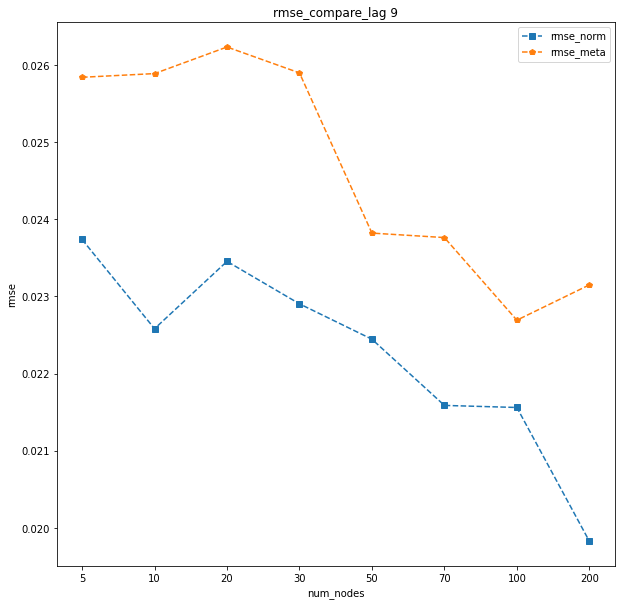

In [ ]:
data = {
    'num_nodes': ["5", "10", "20", "30", "50", "70", "100", "200"],
    'num_lags_norm': [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    'num_lags_meta': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    'r2_norm': [0.971015, 0.970923, 0.972646, 0.975249, 0.973297, 0.974538, 0.975548, 0.977382, 0.97744, 0.980926],
    'rmse_norm': [0.024437, 0.024476, 0.023739, 0.022581, 0.023455, 0.022904, 0.022445, 0.021586, 0.021559, 0.019824],
    'mape_norm': [0.086411, 0.085427, 0.071848, 0.063643, 0.069191, 0.074607, 0.072846, 0.060795, 0.068919, 0.057449],
    'r2_meta': [-0.019541, 0.967016, 0.967581, 0.967459, 0.966588, 0.967439, 0.972456, 0.972589, 0.975006, 0.973986],
    'rmse_meta': [0.14493, 0.026068, 0.025844, 0.025892, 0.026237, 0.025901, 0.023822, 0.023764, 0.022692, 0.02315],
    'mape_meta': [0.792571, 0.089614, 0.085897, 0.085423, 0.088867, 0.086647, 0.076426, 0.070683, 0.067522, 0.072052]
}



# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['rmse_norm'][2:], 's--', label='rmse_norm')


plt.plot(data['num_nodes'], data['rmse_meta'][2:], 'p--', label='rmse_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('rmse')
plt.title("rmse_compare_lag 9")
plt.legend()

# Show the plot
plt.show()


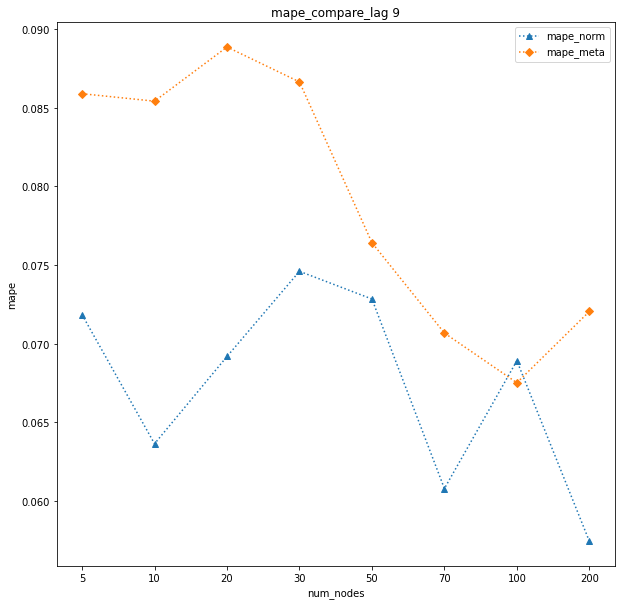

In [ ]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['mape_norm'][2:], ':^', label='mape_norm')
plt.plot(data['num_nodes'], data['mape_meta'][2:], ':D', label='mape_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('mape')
plt.title("mape_compare_lag 9")
plt.legend()

# Show the plot
plt.show()

## Lag=19:

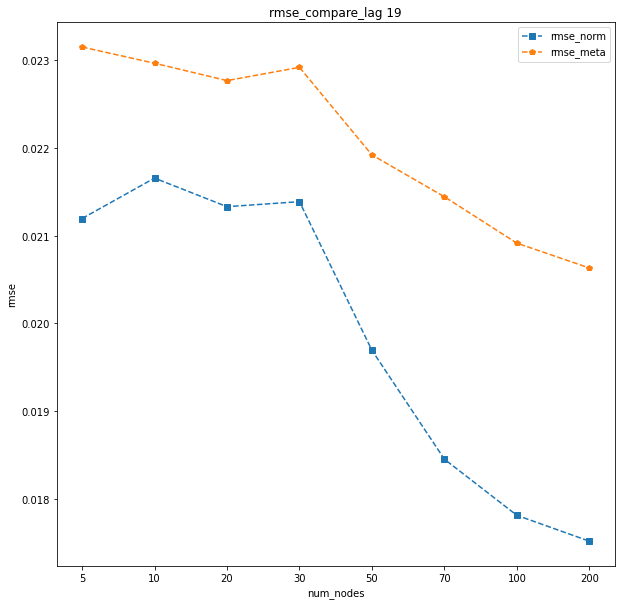

In [ ]:
data = {
    'num_nodes': ["5", "10", "20", "30", "50", "70", "100", "200"],
     'num_lags_norm': [19, 19, 19, 19, 19, 19, 19, 19, 19, 19],
        'num_lags_meta': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
        'r2_norm': [-0.024467, -0.029026, 0.978197, 0.977239, 0.977918, 0.977801, 0.981179, 0.983479, 0.984606, 0.985112],
        'rmse_norm': [0.145287, 0.14561, 0.021195, 0.021656, 0.02133, 0.021387, 0.019692, 0.01845, 0.01781, 0.017515],
        'mape_norm': [0.800525, 0.807715, 0.06551, 0.064513, 0.069121, 0.06491, 0.057803, 0.056721, 0.055471, 0.05684],
        'r2_meta': [-0.021219, 0.973717, 0.973987, 0.974402, 0.97484, 0.974506, 0.976681, 0.977684, 0.978772, 0.979341],
        'rmse_meta': [0.145057, 0.023271, 0.023151, 0.022966, 0.022768, 0.022919, 0.02192, 0.021443, 0.020914, 0.020631],
        'mape_meta': [0.795034, 0.087193, 0.084712, 0.080456, 0.073707, 0.071254, 0.070782, 0.068902, 0.067121, 0.06878]}





# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['rmse_norm'][2:], 's--', label='rmse_norm')


plt.plot(data['num_nodes'], data['rmse_meta'][2:], 'p--', label='rmse_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('rmse')
plt.title("rmse_compare_lag 19")
plt.legend()

# Show the plot
plt.show()


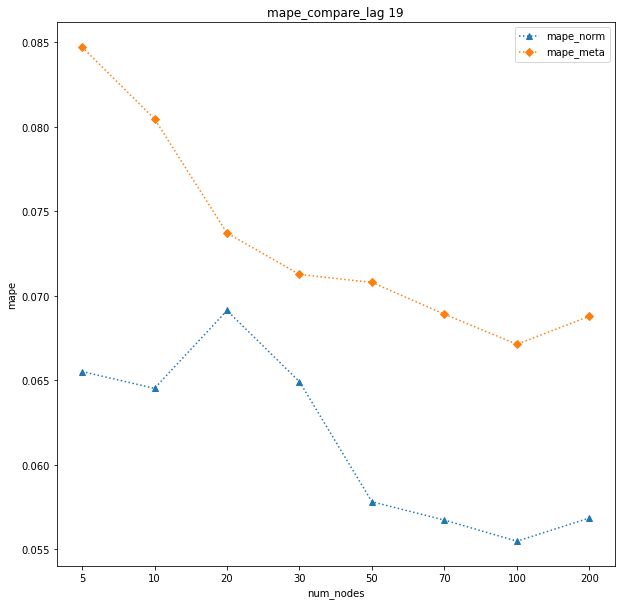

In [ ]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['mape_norm'][2:], ':^', label='mape_norm')
plt.plot(data['num_nodes'], data['mape_meta'][2:], ':D', label='mape_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('mape')
plt.title("mape_compare_lag 19")
plt.legend()

# Show the plot
plt.show()

## Lag=41:

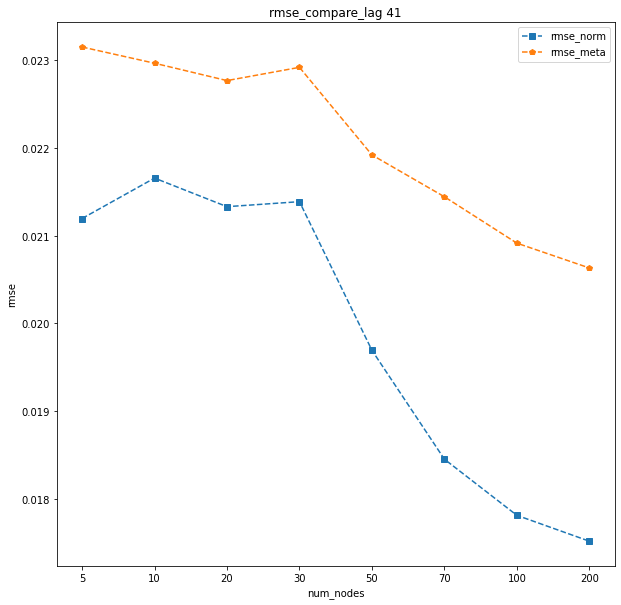

In [ ]:
data = {
    'num_nodes': ["5", "10", "20", "30", "50", "70", "100", "200"],
   'num_lags_norm': [19, 19, 19, 19, 19, 19, 19, 19, 19, 19],
    'num_lags_meta': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    'r2_norm': [-0.024467, -0.029026, 0.978197, 0.977239, 0.977918, 0.977801, 0.981179, 0.983479, 0.984606, 0.985112],
    'rmse_norm': [0.145287, 0.14561, 0.021195, 0.021656, 0.02133, 0.021387, 0.019692, 0.01845, 0.01781, 0.017515],
    'mape_norm': [0.800525, 0.807715, 0.06551, 0.064513, 0.069121, 0.06491, 0.057803, 0.056721, 0.055471, 0.05684],
    'r2_meta': [-0.021219, 0.973717, 0.973987, 0.974402, 0.97484, 0.974506, 0.976681, 0.977684, 0.978772, 0.979341],
    'rmse_meta': [0.145057, 0.023271, 0.023151, 0.022966, 0.022768, 0.022919, 0.02192, 0.021443, 0.020914, 0.020631],
    'mape_meta': [0.795034, 0.087193, 0.084712, 0.080456, 0.073707, 0.071254, 0.070782, 0.068902, 0.067121, 0.06878]
}





# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['rmse_norm'][2:], 's--', label='rmse_norm')


plt.plot(data['num_nodes'], data['rmse_meta'][2:], 'p--', label='rmse_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('rmse')
plt.title("rmse_compare_lag 41")
plt.legend()

# Show the plot
plt.show()


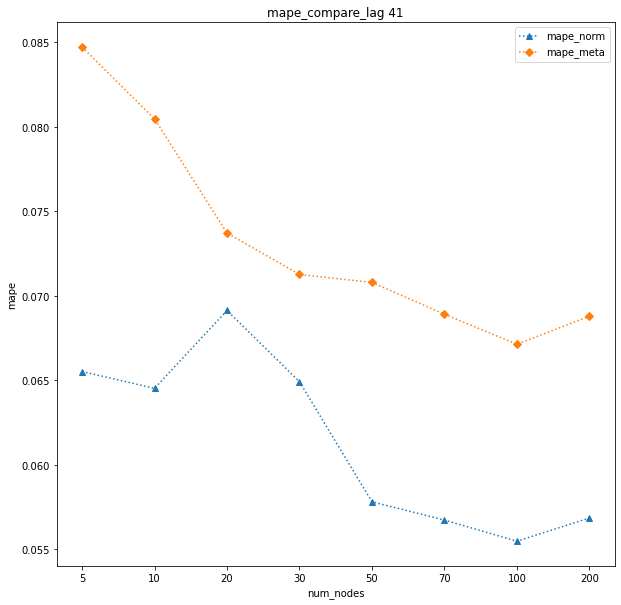

In [ ]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['mape_norm'][2:], ':^', label='mape_norm')
plt.plot(data['num_nodes'], data['mape_meta'][2:], ':D', label='mape_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('mape')
plt.title("mape_compare_lag 41")
plt.legend()

# Show the plot
plt.show()

## Lag=101:

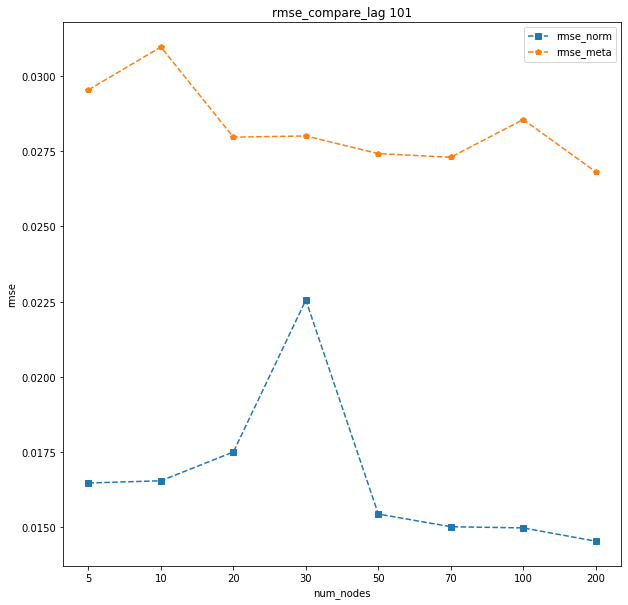

In [ ]:
data = {
    'num_nodes': ["5", "10", "20", "30", "50", "70", "100", "200"],
     "num_lags_norm": [101] * 10,
    "num_lags_meta": [8] * 10,
    "r2_norm": [0.984727, 0.984795, 0.986815, 0.986694, 0.985114, 0.975301, 0.988411, 0.989036, 0.989093, 0.989726],
    "rmse_norm": [0.017734, 0.017694, 0.016477, 0.016552, 0.017507, 0.022552, 0.015447, 0.015025, 0.014986, 0.014545],
    "mape_norm": [0.059653, 0.058568, 0.051293, 0.053538, 0.056287, 0.089875, 0.046832, 0.047618, 0.045649, 0.048581],
    "r2_meta": [0.957889, 0.957953, 0.957638, 0.95346, 0.962024, 0.961921, 0.963494, 0.963818, 0.960417, 0.965085],
    "rmse_meta": [0.029447, 0.029424, 0.029534, 0.030957, 0.027964, 0.028002, 0.027417, 0.027295, 0.028549, 0.026813],
    "mape_meta": [0.101032, 0.102064, 0.099735, 0.099404, 0.092126, 0.091848, 0.089451, 0.088101, 0.088312, 0.086976],
}


# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['rmse_norm'][2:], 's--', label='rmse_norm')


plt.plot(data['num_nodes'], data['rmse_meta'][2:], 'p--', label='rmse_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('rmse')
plt.title("rmse_compare_lag 101")
plt.legend()

# Show the plot
plt.show()


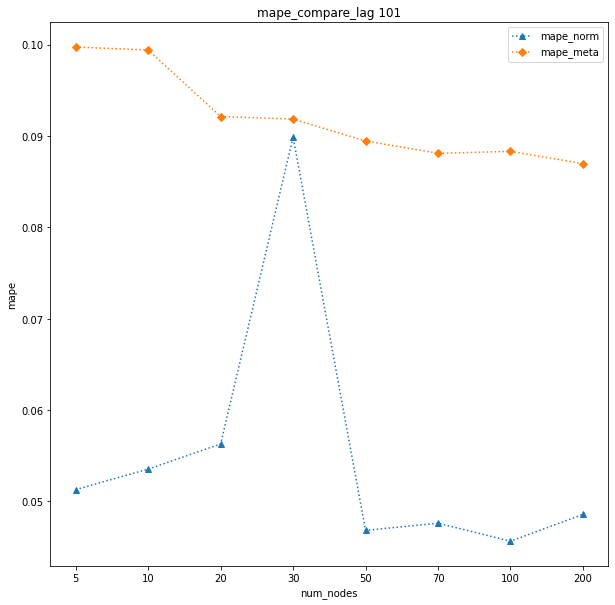

In [ ]:
# Plotting
plt.figure(figsize=(10,10))

plt.plot(data['num_nodes'], data['mape_norm'][2:], ':^', label='mape_norm')
plt.plot(data['num_nodes'], data['mape_meta'][2:], ':D', label='mape_meta')

# Labels and legend
plt.xlabel('num_nodes')
plt.ylabel('mape')
plt.title("mape_compare_lag 101")
plt.legend()

# Show the plot
plt.show()